# 1 Agent-on-pores 2D model (thin agent layer)

## 1.1 Variational formulation and FEniCS implementation


In this first section, we try to get comfortable with FEniCS and the finite element method, by implementing it for a partial aspect of the problem at hand. 

In 2D, the nondimensional rescaled PDE for the cleanser concentration $c(x,y,t)$ becomes (whenever $R>0$, ignoring the case when $R = 0$ for now!):

\begin{equation}
c_t = \nabla^2 c - (1+\chi^\star c)c.
\end{equation}

This comes from equation $(6.7)$ in the first draft of the paper. 

Assume that we are working in a spatial domain $\Omega$, that the initial concentration is prescribed as a non-dimensional function, i.e. $c(x,y,0) = c_0$, and that the concentration is known on (parts of) the boundary, i.e. $c = c_D$ on $\partial \Omega$. We take $c_0 \equiv 0$, since we assume that there is no cleanser initially, before we start to decontaminate the spill.

To start off, we solve the problem over a unit square, so that $\Omega = [0,1] \times [0,1]$. The appropriate boundary conditions for our physical situation are as follows: there is cleanser on the surface, with the deepest point and the ends being insulated:

\begin{equation}
c(x,0,t) = 1, \\
\dfrac{\partial c}{\partial y}(x,1,t) = 0, \\
\dfrac{\partial c}{\partial x}(0,y,t) = 0, \\
\dfrac{\partial c}{\partial x}(1,y,t) = 0.
\end{equation}

Physically, the conditions correspond to the following observations:


#### 1. Initially, there is no cleanser applied and the radius of the coating agent is prescribed. 
#### 2. The cleanser is applied at the surface of the spill $(y=0)$ with a known initial concentration.
#### 3. No cleanser can leave our porous box, so the side ends and the bottom are insulated. 

These boundary conditions are mixed (Dirichlet and Neumann): we have Dirichlet conditions at $y=0, y=1$ (as we specify the cleanser concentration) and Neumann conditions at $y=0, y=1$ (due to the insulation). The Dirichlet conditions are called <b>essential</b> boundary conditions, since we encode them in the definition of spaces. Meanwhile, the Neumann condition is encoded in the variational form itself - this is a <b>weakly imposed</b> boundary condition. 

The approach is to discretise the time derivative, to obtain many stationary problems on the grid. In turn, each of these stationary problems into variational problems, placed into weak form and solved using the finite element method in FEniCS. 

The superscripts denote the timepoint at which we evaluate the solution, so that $c^n$ is the cleanser concentration at time $t_n$. Using an implicit difference scheme, at time $t_{n+1}$ our discretised problem reads:

\begin{equation}
\dfrac{c^{n+1}-c^n}{\Delta t} = \nabla^2 c^{n+1} - (1+\chi^\star c^{n+1})c^{n+1},
\end{equation}

or placing late terms on the left side and early terms on the right side:

\begin{equation}
c^{n+1} - \Delta t \nabla^2 c^{n+1} + \Delta t (1+\chi^\star c^{n+1})c^{n+1}= c^n.
\end{equation}

Introduce the new spaces: 

\begin{equation}
V = \{v \in H^1(\Omega) | v = c_D \text{ on } \partial \Omega \cap \{ y=0 \} \}, \\
\hat{V} = \{v \in H^1(\Omega) | v = 0 \text{ on } \partial \Omega \cap \{ y=0 \} \},
\end{equation}

which are the (continuous) function spaces that contain our solutions and the suitable test functions for the variational problem, respectively. We implicitly work with strict subspaces of these spaces in seeking solutions to the discretised problem (finite dimensional Galerkin approximations).

Next, we multiply the discretised problem by a test function $v$ which vanishes on the boundary of the domain (wherever the solution is actually specified), and we write $c$ for $c^{n+1}$ (thereby keeping $c^n$ in its original notation). Using Green's theorem in the second equality and since the test function vanishes on $\partial \Omega \cap \{ y = 0 \}$ and $\partial \Omega \cap \{ y = 1 \}$, whereas the normal derivative of $c$ vanishes on the remainder of the boundary:

\begin{equation}
\int_{ \Omega} v \nabla^2 c dxdy= \int_{ \Omega} \nabla \cdot (v \nabla c) dxdy - \int_{ \Omega} \nabla v \cdot \nabla c dxdy = \int_{\partial \Omega} v \dfrac{\partial c}{\partial n} ds- \int_{ \Omega} \nabla v \cdot \nabla c dxdy = - \int_{ \Omega} \nabla v \cdot \nabla c dxdy.
\end{equation}

<b> The important takeaway here is that no boundary integrals remain and the variational formulation is as simple as possible. </b> 

Therefore, in integral form the problem becomes: find $u \in V$ such that for any $v \in \hat{V}$, we have:

\begin{equation}
F_{n+1}(c;v) = \int_{\Omega} vc + \Delta t (\nabla v \cdot \nabla c) + v \Delta t (1+ \chi^\star c)c - vc^n dx dy = 0.
\end{equation}

Note that this problem is not in the canonical form $F(c;v) = 0 = a(c;v) - L(v)$, where $a$ is a bilinear form and $L$ is a linear mapping, because of the nonlinearity due to the extra diffusion terms. However, we may simply leave the problem in this form, and FEniCS automatically handles the non-linearity using Newton-Kantorovich, provided it converges in sufficiently many steps.

We can actually go one step further to improve the stability and accuracy of this method, by considering an <b> implicit midpoint </b> method. In particular, we only need to change the right hand side to reflect the average of our variable at times $t_{n+1}$ and $t_n$, as follows: 

\begin{equation}
\dfrac{c^{n+1}-c^n}{\Delta t} = \dfrac{1}{2} \nabla^2 \left( c^{n+1} +  c^{n} \right) - \left(1+\chi^\star \dfrac{c^{n+1}+c^n}{2}\right) \dfrac{c^{n+1}+c^n}{2}.
\end{equation}

In the code below, this is reflected by defining $\tilde{c} = \frac{1}{2} \left( c^{n+1} + c^{n} \right)$ and using it as a replacement for c, everywhere except for the term due to the time derivative on the left hand side. This gives a new variational formulation (upon division by $\Delta t$):

\begin{equation}
F_{n+1}(c;v) = \int_{\Omega} \dfrac{v(c-c^n)}{\Delta t} + \nabla v \cdot \nabla \tilde{c} + v  (1+ \chi^\star \tilde{c})\tilde{c} dx dy = 0.
\end{equation}

## 1.2 Plotting the 2D solution with a color plot

We can then simulate the solution of the equation as follows:

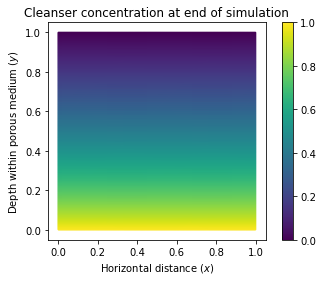

In [1]:
from __future__ import print_function
from fenics import * # imports the key classes UnitSquareMesh, FunctionSpace, Function etc.
import numpy as np # we'll need this, always - most matrix-y operations use numpy
from matplotlib import pyplot as plt # go-to plotter, MATLAB style
 
T = 1           # time of solution (end of simulation)
num_steps = 30     # number of time steps
dt = T / num_steps # time step size (predetermined by the number of timesteps)
chi = 1         # parameter chi star
degree = 1 # the degree that determines the kind of elements we are using for the function space


# Create mesh and define function space
nx = ny = 200 # Specifying the resolution of our triangular mesh
mesh = UnitSquareMesh(nx, ny) # Uniform, finite element mesh over the unit square.
# The mesh consists of cells, which in 2D are triangles with straight lines.

V = FunctionSpace(mesh, 'P', degree)
# A finite element function space. The second argument specifies the type of element.
# 'P' means that we are using the standard Lagrange family of elements.
# The third argument specifies the degree of the finite element.
# Patrick says that this is a sensible choice and should do the job, so I will stick with it. 

# Define boundary condition - there is no cleanser initially at t = 0!
c_init = Expression('0', degree=2, t=0) 
# Here x[0] is our usual x (horizontal distance), x[1] is our y (vertical distance)
# Warning! Expressions must have a C syntax for inline branching, not a Python one.

tol = 1e-14 # a tiny tolerance that helps us locate the suitable parts of the boundary. 

class BoundaryX0(SubDomain): # defining the boundary at x = 0
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0, tol)

class BoundaryX1(SubDomain): # defining the boundary at x = 1
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 1, tol)

class BoundaryY0(SubDomain): # defining the boundary at y = 0
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0, tol)

class BoundaryY1(SubDomain): # defining the boundary at y = 1
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 1, tol)  
    
# We are working with facets, so from the FEniCS documentation we need -1 of the dimension of the mesh topology. 
# If instead we wanted to work with vertices, the dimension would be -2. 
boundary_markers = MeshFunction('size_t', mesh, mesh.topology().dim()-1, 0) 
# This was previously done with a FacetFunction, which has now deprecated within FEniCS. 
boundary_markers.set_all(9999)
bx0 = BoundaryX0()
bx1 = BoundaryX1()
by0 = BoundaryY0()
by1 = BoundaryY1()
bx0.mark(boundary_markers, 0) # Assigning a "0" marker to x = 0 
bx1.mark(boundary_markers, 1) # Assigning a "1" marker to x = 1 
by0.mark(boundary_markers, 2) # Assigning a "2" marker to y = 0 
by1.mark(boundary_markers, 3) # Assigning a "3" marker to y = 1 

# In this dictionary, we specify the kinds of boundary conditions we are dealing with. 
# There are three possibilities: Dirichlet, Neumann and Robin.
# For each kind of condition, to the right we specify the function that this condition is assigned.

boundary_conditions = {0: {'Neumann': Expression('0', degree=2)}, # insulated left end
                        1: {'Neumann': Expression('0', degree=2)}, # insulated right end
                        2: {'Dirichlet': Expression('1', degree=2)}, # initial cleanser concentration on surface
                        3: {'Dirichlet': Expression('0', degree=2)}} # no cleanser has penetrated the maximum depth

bcs = [] # We first start with an empty array of boundary conditions. 
# Next, we fill this array only with Dirichlet conditions, since these are the only ones which are taken 
# into account explicitly, as opposed to within the variational formulation of the problem itself. 
for i in boundary_conditions:
    if 'Dirichlet' in boundary_conditions[i]:
        bc = DirichletBC(V, boundary_conditions[i]['Dirichlet'],
                        boundary_markers, i)
        bcs.append(bc)

# Define initial value
c_n = interpolate(c_init, V)
#c_n = project(u_D, V), depending on whether we want to interpolate or project the boundary data.

# Define variational problem

c = interpolate(c_init, V) # A good initial guess is our initial value! 
v = TestFunction(V)

# The "c tilde" for the implicit midpoint method. 
c_=1/2*(c+c_n)

# Variational formulation
F = (c-c_n)/dt*v*dx + dot(grad(c_), grad(v))*dx + v*(1 + chi*c_)*c_*dx
# language used to express this syntax is UFL (Unified Form Language) and is integral to FEniCS.

# Time-stepping
t = 0
for n in range(num_steps):

    # Update current time
    t += dt # add the timestep to the current time to move forward
    c_init.t = t # update the time 

    # Compute solution
    solve(F == 0, c, bcs) # Apply Newton-Kantorovich to nonlinear problem, with the specified boundary conditions
    
    # Update previous solution
    c_n.assign(c) # We assign the values of c to c_n which contains values from previous timestep
    # Do not try to set c_n = c, as that will make the two variables exactly the same

# Plot solution at the end of the simulation
plt.figure(0)
simulationplot = plot(c, title = "Cleanser concentration at end of simulation", mode = 'color')
plt.xlabel("Horizontal distance $(x)$")
plt.ylabel("Depth within porous medium $(y)$")
    
# Plot the colorbar for the given problem
plt.colorbar(simulationplot)


# 2 Agent-on-pores 1D model (thin agent layer)

## 2.1 Adapting our solver for 1D

We aim to solve the following problem using the finite element method:

\begin{equation}
c_t = c_{yy} - (1+ \chi^{\star} c) c,
\end{equation}

for $y \in [0, \infty)$ and $t > 0$, subject to:
\begin{equation}
c(y,0) = 0, \\
c(0,t) = 1, \\
c(y,t) \to 0 \text{ as } y \to \infty.
\end{equation}

We preserve the variational formulation from above, with the obvious changes incorporated (eg. the Laplacian is only in 1D). 

The only changes in the code comme from redefining the boundaries (we are dealing with a segment instead of a rectangle), changing the mesh and adding periodic plotting. 

In [2]:
from __future__ import print_function
from fenics import * # imports the key classes UnitSquareMesh, FunctionSpace, Function etc.
import numpy as np # we'll need this, always - most matrix-y operations use numpy
from matplotlib import pyplot as plt # go-to plotter, MATLAB style
 

def agentonpores_simple_1d(T, num_steps, chi, subintervals, max_depth, bc_maxdepth, plot_frequency):    
    
    dt = T / num_steps # time step size (predetermined by the number of timesteps)
    degree = 1 # the degree that determines the kind of elements we are using for the function space

    # Create mesh and define function space

    mesh = IntervalMesh(subintervals, 0, max_depth) 
    # Splitting the interval [0, max_depth] into gridspacing many equal sub-intervals.
    
    element = FiniteElement("Lagrange", interval, degree)
    V = FunctionSpace(mesh, element)
    # We are using the standard Lagrange family of elements.
    # The third argument specifies the degree of the finite element (here we use linear element).
    # In spatial 1D, this is simply an interval. 

    # Define initial condition - there is no cleanser initially at t = 0!
    c_init = Expression('0', degree=1, t=0) 
    # Here x[0] is our usual x (horizontal distance), x[1] is our y (vertical distance)
    # Warning! Expressions must have a C syntax for inline branching, not a Python one.

    tol = 1e-14 # a tiny tolerance that helps us locate the suitable parts of the boundary. 

    class BoundaryX0(SubDomain): # defining the boundary at  y = 0
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 0, tol)

    class BoundaryX1(SubDomain): # defining the boundary at y = max_depth
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], max_depth, tol)
    
    # We are working with facets, so from the FEniCS documentation we need -1 of the dimension of the mesh topology. 
    # If instead we wanted to work with vertices, the dimension would be -2. 
    boundary_markers = MeshFunction('size_t', mesh, mesh.topology().dim()-1, 0) 
    # This was previously done with a FacetFunction, which has now deprecated within FEniCS. 
    
    # We now extract the boundaries so we can work with them directly. 
    boundary_markers.set_all(9999)
    bx0 = BoundaryX0()
    bx1 = BoundaryX1()
    bx0.mark(boundary_markers, 0) # Assigning a "0" marker to y = 0 
    bx1.mark(boundary_markers, 1) # Assigning a "1" marker to y = max_depth

    # In this dictionary, we specify the kinds of boundary conditions we are dealing with. 
    # There are three possibilities: Dirichlet, Neumann and Robin.
    # For each kind of condition, to the right we specify the function that this condition is assigned.

    boundary_conditions = {0: {'Dirichlet': Expression('1', degree=2)}, # applying cleanser at the surface
                            1: {bc_maxdepth: Expression('0', degree=2)}} # no cleanser has penetrated max depth

    bcs = [] # We first start with an empty array of boundary conditions. 
    # Next, we fill this array only with Dirichlet conditions, since these are the only ones which are taken 
    # into account explicitly, as opposed to within the variational formulation of the problem itself. 
    for i in boundary_conditions:
        if 'Dirichlet' in boundary_conditions[i]:
            bc = DirichletBC(V, boundary_conditions[i]['Dirichlet'],
                            boundary_markers, i)
            bcs.append(bc)

    # Define initial value
    c_n = interpolate(c_init, V)
    #c_n = project(u_D, V), depending on whether we want to interpolate or project the boundary data.

    # Define variational problem

    c = interpolate(c_init, V) # A good initial guess is our initial value! 
    v = TestFunction(V) # We will need a test function for the variational formulation

    # The "c tilde" for the implicit midpoint method. 
    c_=1/2*(c+c_n)

    # Variational formulation
    F = (c-c_n)/dt*v*dx + dot(grad(c_), grad(v))*dx + v*(1 + chi*c_)*c_*dx
    # language used to express this syntax is UFL (Unified Form Language) and is integral to FEniCS.

    # Time-stepping
    t = 0 # We start at zero time, obviously
    plot_counter = 0 # Used with plot frequency to add new timepoints to plot
    
    for n in range(num_steps):

        # Update current time
        t += dt # add the timestep to the current time to move forward
        c_init.t = t # update the time 
        plot_counter += 1 # updating the plot_counter as we move forward in time

        # Compute solution
        solve(F == 0, c, bcs) # Apply Newton-Kantorovich to nonlinear problem, with the specified boundary conditions
        
        # Update previous solution
        c_n.assign(c) # We assign the values of c to c_n which contains values from previous timestep
        # Do not try to set c_n = c, as that will make the two variables exactly the same
        
        # Plot as frequently as we'd like to
        if plot_counter % plot_frequency == 0:
            # Plotting the solution with the desired frequency: 
            plot(c, title = "Cleanser concentration at a given time", label = "$t=$" + str(round(t,3)))
            plt.xlabel("Depth within porous medium $(y)$")
            plt.ylabel("Cleanser concentration $c(y,t)$")
            plt.legend()
        
            

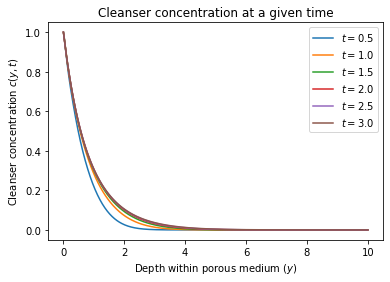

In [3]:
# Time Parameters

T = 3 # time of solution (end of simulation)
num_steps = 60 # number of time steps
plot_frequency = 10 # plot every i-th iteration in time

# Space Parameters

subintervals = 500 # Specifying the number of sub-intervals in our interval
max_depth = 10 # Solving the PDE for y in [0, max_depth]

# Reaction parameter

chi = 1 # parameter chi star

# Type of boundary condition

bc_maxdepth = 'Dirichlet'

agentonpores_simple_1d(T, num_steps, chi, subintervals, max_depth, bc_maxdepth, plot_frequency)

## 2.2 Is our solver at all reasonable?

To test the validity of our solver, we compare the numerical solution in the case when $\chi^{\star} = 0$, so that we may write down an explicit solution. That is, we start with the PDE: 

\begin{equation}
c_t = \nabla^2 c - c.
\end{equation}

The accompanying boundary conditions are as follows:

\begin{equation}
c(y,0) = 0, \\
c(0,t) = 1, \text{ for } t > 0, \\
c(y,t) \to 0 \text{ as } y \to \infty.
\end{equation}

We seek a solution using the Fourier transform. Let $\hat{c}$ denote a Fourier transform, so that $c(y,t)$ transforms to $\hat{c}(s,t)$. Our Green's function $G(y,t; \xi, \tau)$ for the problem on the half-line satisfies:

\begin{equation}
G_t + G_{yy} - G = 0,
\end{equation}

for $y \in [0, \infty)$ and $t>0$, with conditions:

\begin{equation}
G = 0 \text{ on } y = 0, \\
G \to 0 \text{ as } y \to \infty, \\
G = \delta (y - \xi) \text{ at } t = \tau.
\end{equation}

We make a change of variable as follows: $x = y - \xi$, $\tilde{t} = t - \tau$. The problem then becomes (abusing notation and writing $G(y,t) = G(x, \tilde{t})$):

\begin{equation}
G_{\tilde{t}} = G_{xx} - G,
\end{equation}

with the second and third conditions becoming:

\begin{equation}
G \to 0 \text{ as } x \to \infty, \\
G = \delta (x) \text{ at } \tilde{t} = 0.
\end{equation}

By taking a Fourier transform in the $x$ variable (denoted with a hat), we obtain the following PDE:

\begin{equation}
\hat{G}_{\tilde{t}} + (1+s^2) \hat{G} = 0,
\end{equation}

which has the solution (via an integrating factor): 

\begin{equation}
\hat{G}(s, \tilde{t}) = K(s) \exp \left( -(1+s^2)\tilde{t} \right).
\end{equation}

However, at $\tilde{t} = 0$, we have $G = \delta(x)$, so $\hat{G}(s,0) = 1$. This implies $K(s) = 1$. 

Using the Fourier inversion formula, we have; 

\begin{equation}
G(x, \tilde{t}) = \dfrac{1}{2 \pi} \int_{-\infty}^{\infty} \hat{G}(s,\tilde{t}) e^{isx} ds = \dfrac{e^{-\tilde{t}}}{2 \pi} \int_{-\infty}^{\infty} e^{t \left(is + \frac{x}{2 \tilde{t}} \right)^2} e^{-\frac{x^2}{4 \tilde{t}}}ds. 
\end{equation}

However, for any $\lambda \in \mathbb{C}$, we have that: 

\begin{equation}
\int_{-\infty}^{\infty} e^{-(u - \lambda)^2} du = \sqrt{\pi}.
\end{equation}

Therefore, by a change of variable in the integral, we obtain:

\begin{equation}
G(x, \tilde{t}) = \dfrac{1}{\sqrt{4 \pi \tilde{t}}} e^{- \tilde{t}-\frac{x^2}{4 \tilde{t}}},
\end{equation}

or switching to the original variables, this is:

\begin{equation}
G(y, t; \xi, \tau) = \dfrac{1}{\sqrt{4 \pi (\tau - t)}} e^{- (\tau - t)-\frac{(y - \xi)^2}{4 (\tau - t)}},
\end{equation}

Note that this satisfies two out of the three desired conditions, so that $G \to 0 \text{ as } y \to \infty$, and $G = \delta (y - \xi) \text{ at } t = \tau$. However, 

\begin{equation}
G(0, t; \xi, \tau) = \dfrac{1}{\sqrt{4 \pi (\tau - t)}} e^{- (\tau - t)-\frac{\xi^2}{4 (\tau - t)}},
\end{equation}

whereas we need $G = 0$ at $y = 0$. Therefore, we make use of an image point $(-\xi, \tau)$ opposite of $(\xi, \tau)$ with respect to the $y$-axis. So our final Green's function is: 

\begin{equation}
G(y, t; \xi, \tau) = \dfrac{e^{-(\tau - t)}}{\sqrt{4 \pi (\tau - t)}} \left( e^{-\frac{(y - \xi)^2}{4 (\tau - t)}} - e^{-\frac{(y + \xi)^2}{4 (\tau - t)}}  \right).
\end{equation}

Next, using Green's theorem (exactly in the same way as the regular heat equation), we may derive an explicit solution in terms of this Green's function: 

\begin{equation}
c(\xi, \tau) = \int_{0}^{\tau} \dfrac{\partial G}{\partial y} (0,t; \xi, \tau) dt = \int_{0}^{\tau} \dfrac{\xi e^{-(\tau - t) - \frac{\xi^2}{4(\tau - t)}}}{\sqrt{4 \pi (\tau - t)^3}} dt.
\end{equation}

Expressed in our usual variables, we can rewrite this as (valid for $y > 0$):

\begin{equation}
c(y, T) =  \int_{0}^{T} \dfrac{y e^{-(T - t) - \frac{y^2}{4(T - t)}}}{\sqrt{4 \pi (T - t)^3}} dt.
\end{equation}

We now compare this to the actual solution, by plotting both alongside each other.

In [6]:
from __future__ import print_function
from fenics import * # imports the key classes UnitSquareMesh, FunctionSpace, Function etc.
import numpy as np # we'll need this, always - most matrix-y operations use numpy
from matplotlib import pyplot as plt # go-to plotter, MATLAB style
from scipy import integrate, special # we will need scipy for numerical integration
from scipy.integrate import quad


def agentonpores_regimes(T, subintervals, max_depth):    
    
    subintervals = int(np.ceil(max_depth*100)) 
    num_steps = int(np.ceil(T*50))
    dt = T / num_steps # time step size (predetermined by the number of timesteps)


    degree = 1 # the degree that determines the kind of elements we are using for the function space

    # Create mesh and define function space

    mesh = IntervalMesh(subintervals, 0, max_depth) 
    # Splitting the interval [0, max_depth] into gridspacing many equal sub-intervals.
    
    element = FiniteElement("Lagrange", interval, degree)
    V = FunctionSpace(mesh, element)
    # We are using the standard Lagrange family of elements.
    # The third argument specifies the degree of the finite element (here we use linear element).
    # In spatial 1D, this is simply an interval. 

    # Define initial condition - there is no cleanser initially at t = 0!
    c_init = Expression('0', degree=1, t=0) 
    # Here x[0] is our usual x (horizontal distance), x[1] is our y (vertical distance)
    # Warning! Expressions must have a C syntax for inline branching, not a Python one.

    tol = 1e-14 # a tiny tolerance that helps us locate the suitable parts of the boundary. 

    class BoundaryX0(SubDomain): # defining the boundary at  y = 0
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 0, tol)

    class BoundaryX1(SubDomain): # defining the boundary at y = max_depth
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], max_depth, tol)
    
    # We are working with facets, so from the FEniCS documentation we need -1 of the dimension of the mesh topology. 
    # If instead we wanted to work with vertices, the dimension would be -2. 
    boundary_markers = MeshFunction('size_t', mesh, mesh.topology().dim()-1, 0) 
    # This was previously done with a FacetFunction, which has now deprecated within FEniCS. 
    
    # We now extract the boundaries so we can work with them directly. 
    boundary_markers.set_all(9999)
    bx0 = BoundaryX0()
    bx1 = BoundaryX1()
    bx0.mark(boundary_markers, 0) # Assigning a "0" marker to y = 0 
    bx1.mark(boundary_markers, 1) # Assigning a "1" marker to y = max_depth

    # In this dictionary, we specify the kinds of boundary conditions we are dealing with. 
    # There are three possibilities: Dirichlet, Neumann and Robin.
    # For each kind of condition, to the right we specify the function that this condition is assigned.

    chi = 0 
    
    while chi < 8.1: 
        
        boundary_conditions = {0: {'Dirichlet': Expression('1', degree=2)}, # applying cleanser at the surface
                            1: {'Dirichlet': Expression('0', degree=2)}} # no cleanser has penetrated max depth

        bcs = [] # We first start with an empty array of boundary conditions. 
        # Next, we fill this array only with Dirichlet conditions, since these are the only ones which are taken 
        # into account explicitly, as opposed to within the variational formulation of the problem itself. 
        for i in boundary_conditions:
            if 'Dirichlet' in boundary_conditions[i]:
                bc = DirichletBC(V, boundary_conditions[i]['Dirichlet'],
                                boundary_markers, i)
                bcs.append(bc)

        # Define initial value
        c_n = interpolate(c_init, V)
        #c_n = project(u_D, V), depending on whether we want to interpolate or project the boundary data.

        # Define variational problem

        c = interpolate(c_init, V) # A good initial guess is our initial value! 
        v = TestFunction(V) # We will need a test function for the variational formulation

        # The "c tilde" for the implicit midpoint method. 
        c_=1/2*(c+c_n)

        # Variational formulation
        F = (c-c_n)/dt*v*dx + dot(grad(c_), grad(v))*dx + v*(1 + chi*c_)*c_*dx
        # language used to express this syntax is UFL (Unified Form Language) and is integral to FEniCS.
    
        # Time-stepping
        t = 0 # We start at zero time, obviously
        
        for n in range(num_steps):

            # Update current time
            t += dt # add the timestep to the current time to move forward

            # Compute solution
            solve(F == 0, c, bcs) # Apply Newton-Kantorovich to nonlinear problem, with the specified boundary conditions
        
            # Update previous solution
            c_n.assign(c) # We assign the values of c to c_n which contains values from previous timestep
            # Do not try to set c_n = c, as that will make the two variables exactly the same
        
        plt.figure(0)
        plot(c, title = "Cleanser concentration at time $T =$" + str(round(T,1)), label = "$\chi=$" + str(round(chi,2)))
        plt.xlabel("Depth within porous medium $(y)$")
        plt.ylabel("Cleanser concentration $c(y,t)$")
        plt.legend()
        
        chi += 2
        
    def integrand(t, y, T): 
        return y*np.exp(t-T-pow(y,2)/(4*(T-t)))/sqrt(4*np.pi*(T-t)**3)

    def greensintegral(y, T):
        return quad(integrand, 0, T, args=(y, T))[0] 
    
    resultgrid = []
    distancegrid = []
    d = 0.01
    while d < 10: 
        integ = greensintegral(d,3)
        distancegrid.append(d)
        resultgrid.append(integ)
        d += 0.05
    
    plt.figure(0)
    plt.plot(distancegrid, resultgrid, '--', label = "$\chi = 0$ via Green's function")
    plt.legend()


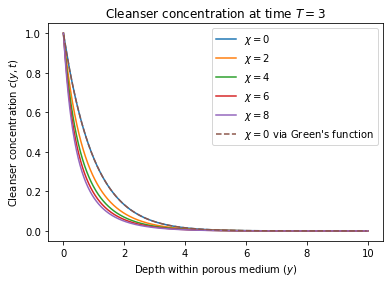

In [7]:
# TESTING THE SOLVER

# Time Parameters

T = 3 # time of solution (end of simulation)

# Space Parameters

subintervals = 500 # Specifying the number of sub-intervals in our interval
max_depth = 10 # Solving the PDE for y in [0, max_depth]

agentonpores_regimes(T, subintervals, max_depth)

Looks like there's almost perfect overlap for $\chi^{\star} = 0$ - yay!